In [1]:
# Import required modules
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the MNIST dataset
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Set batch size for training and testing
batch_size = 100

# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 244071991.90it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 60872207.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 151920817.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11199605.39it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = MLP()

In [3]:
# Define FGSM Attack
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [4]:
# Set number of epochs
num_epochs = 10

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/600], Loss: 0.4135
Epoch [1/10], Step [200/600], Loss: 0.2607
Epoch [1/10], Step [300/600], Loss: 0.2688
Epoch [1/10], Step [400/600], Loss: 0.2443
Epoch [1/10], Step [500/600], Loss: 0.1437
Epoch [1/10], Step [600/600], Loss: 0.1664
Epoch [2/10], Step [100/600], Loss: 0.1107
Epoch [2/10], Step [200/600], Loss: 0.0846
Epoch [2/10], Step [300/600], Loss: 0.0812
Epoch [2/10], Step [400/600], Loss: 0.1282
Epoch [2/10], Step [500/600], Loss: 0.0709
Epoch [2/10], Step [600/600], Loss: 0.0313
Epoch [3/10], Step [100/600], Loss: 0.0367
Epoch [3/10], Step [200/600], Loss: 0.0674
Epoch [3/10], Step [300/600], Loss: 0.0878
Epoch [3/10], Step [400/600], Loss: 0.0410
Epoch [3/10], Step [500/600], Loss: 0.0301
Epoch [3/10], Step [600/600], Loss: 0.0194
Epoch [4/10], Step [100/600], Loss: 0.1126
Epoch [4/10], Step [200/600], Loss: 0.0153
Epoch [4/10], Step [300/600], Loss: 0.0771
Epoch [4/10], Step [400/600], Loss: 0.0768
Epoch [4/10], Step [500/600], Loss: 0.0599
Epoch [4/10

In [5]:
# Test the model on the clean test set
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy on clean test set: {} %'.format(100 * correct / total))

Accuracy on clean test set: 97.96 %


In [6]:
# Test the model on the perturbed test set for different epsilon values
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []
for epsilon in epsilons:
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Set requires_grad attribute of tensor
        images.requires_grad = True

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Zero gradients
        model.zero_grad()

        # Backward pass
        loss.backward()

        # Collect data gradients
        data_grad = images.grad.data

        # Perturb input image with FGSM attack
        perturbed_images = fgsm_attack(images, epsilon, data_grad)

        # Re-classify the perturbed images
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)

        # Count total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy on perturbed test set
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print('Epsilon: {}, Accuracy: {} %'.format(epsilon, accuracy))

Epsilon: 0, Accuracy: 97.96 %
Epsilon: 0.05, Accuracy: 62.14 %
Epsilon: 0.1, Accuracy: 21.46 %
Epsilon: 0.15, Accuracy: 10.37 %
Epsilon: 0.2, Accuracy: 5.58 %
Epsilon: 0.25, Accuracy: 2.85 %
Epsilon: 0.3, Accuracy: 1.4 %


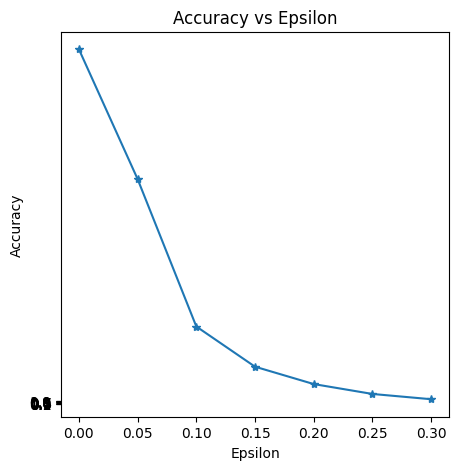

In [7]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()